In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy.optimize import minimize
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.multioutput import MultiOutputRegressor

In [71]:
df = pd.read_excel('dwl_exp.xlsx', sheet_name='main', engine = 'openpyxl')

In [72]:
response_names = ['Foaming', 'Density', 'pH', '1% pH', 'Total_Cost']
component_names = ['DIW', 'SLES', 'ASSA', 'SRBTL', 'SDCL', 'NAOH', 'PRFLS', 'PWDGRN']
cost_per_unit = np.array([0.0006,0.2629,0.2527,0.1400,0.0601,0.1251,5.5006,1.9000])

In [73]:
df['Total_Cost'] = df[component_names].dot(cost_per_unit)

In [74]:
df_components = df[component_names]
df_responses = df[response_names]

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Ex          19 non-null     int64  
 1   DIW         19 non-null     float64
 2   SLES        19 non-null     float64
 3   ASSA        19 non-null     float64
 4   SRBTL       19 non-null     float64
 5   SDCL        19 non-null     float64
 6   NAOH        19 non-null     float64
 7   PRFLS       19 non-null     float64
 8   PWDGRN      19 non-null     float64
 9   Foaming     19 non-null     float64
 10  Density     19 non-null     float64
 11  pH          19 non-null     float64
 12  1% pH       19 non-null     float64
 13  Total_Cost  19 non-null     float64
dtypes: float64(13), int64(1)
memory usage: 2.2 KB


In [76]:
df.describe()

,Ex,DIW,SLES,ASSA,SRBTL,SDCL,NAOH,PRFLS,PWDGRN,Foaming,Density,pH,1% pH,Total_Cost
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,10.000000,0.810662,0.070345,0.069297,0.017252,0.019196,0.011243,0.001100,0.000906,8.897368,239.896842,5.752632,7.036842,0.049239
std,5.627314,0.005698,0.012480,0.013354,0.005693,0.003984,0.002963,0.000741,0.000640,1.790521,232.773817,4.753288,1.169620,0.005223
min,1.000000,0.803536,0.050060,0.050060,0.000984,0.009844,0.007547,0.000050,0.000300,6.000000,65.000000,1.000000,5.100000,0.045366
25%,5.500000,0.807245,0.065171,0.060490,0.015037,0.019983,0.008805,0.001001,0.000301,8.400000,102.200000,2.150000,6.100000,0.047433
50%,10.000000,0.810973,0.070352,0.070309,0.015144,0.020074,0.012480,0.001004,0.000603,9.000000,102.800000,3.300000,7.200000,0.047912
75%,14.500000,0.813008,0.075502,0.070600,0.020125,0.020137,0.012559,0.001007,0.001512,9.625000,310.500000,11.650000,7.850000,0.049000
max,19.000000,0.828074,0.090561,0.100452,0.030295,0.025253,0.019206,0.004018,0.002020,13.800000,962.000000,11.900000,8.800000,0.069999


In [77]:
# histograms, to check distribution of components and responses

sns.set(style="whitegrid")
ndf = df.drop(columns=["Ex"])

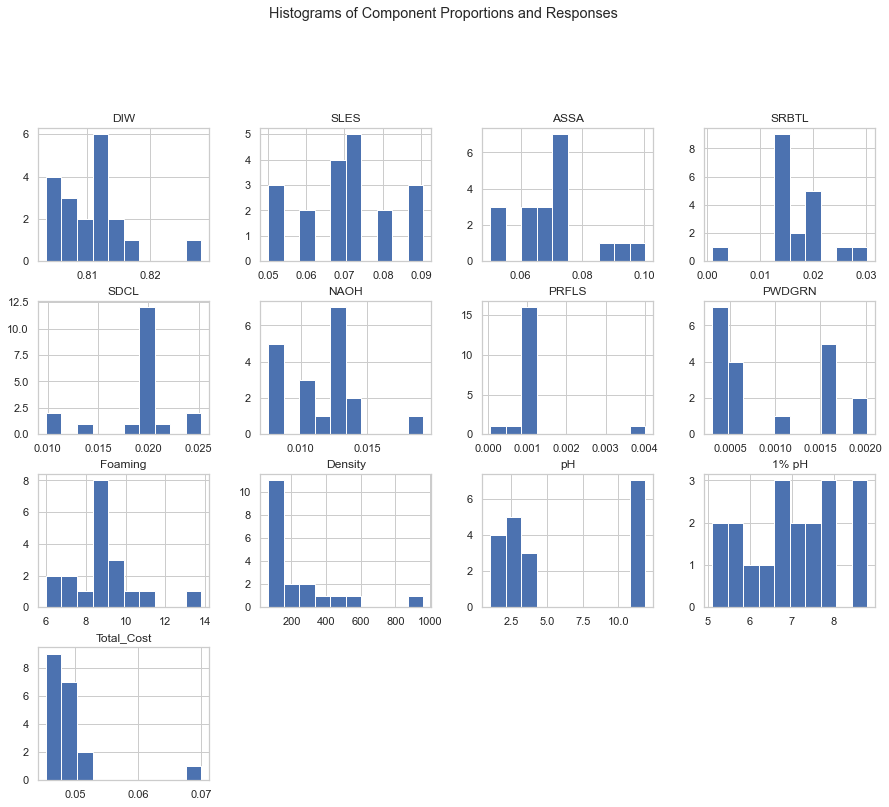

In [78]:
ndf.hist(bins=10, figsize=(15, 12), layout=(4, 4))
plt.suptitle('Histograms of Component Proportions and Responses', y=1.02)
plt.show()

# the mixes could be better spread - note for next run. 

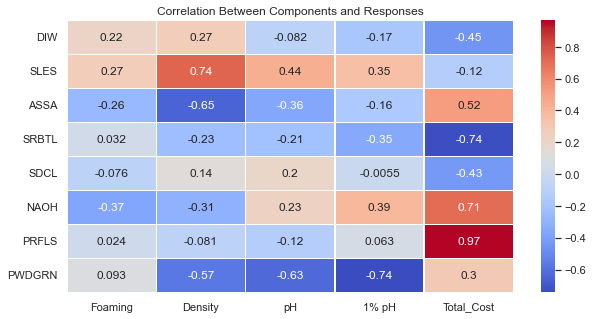

In [79]:
# correlation analysis - single component and response correlation wont make sense, 
correlation_matrix = pd.DataFrame(index=component_names, columns=response_names)

for component in component_names:
    for response in response_names:
        correlation_matrix.loc[component, response] = df[component].corr(df[response])

correlation_matrix = correlation_matrix.astype(float)


plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Between Components and Responses')
plt.show()
# SLES is correlated to density, expected to see negative correlation with NaOH and pH, but ASSA, changes the interaction. 

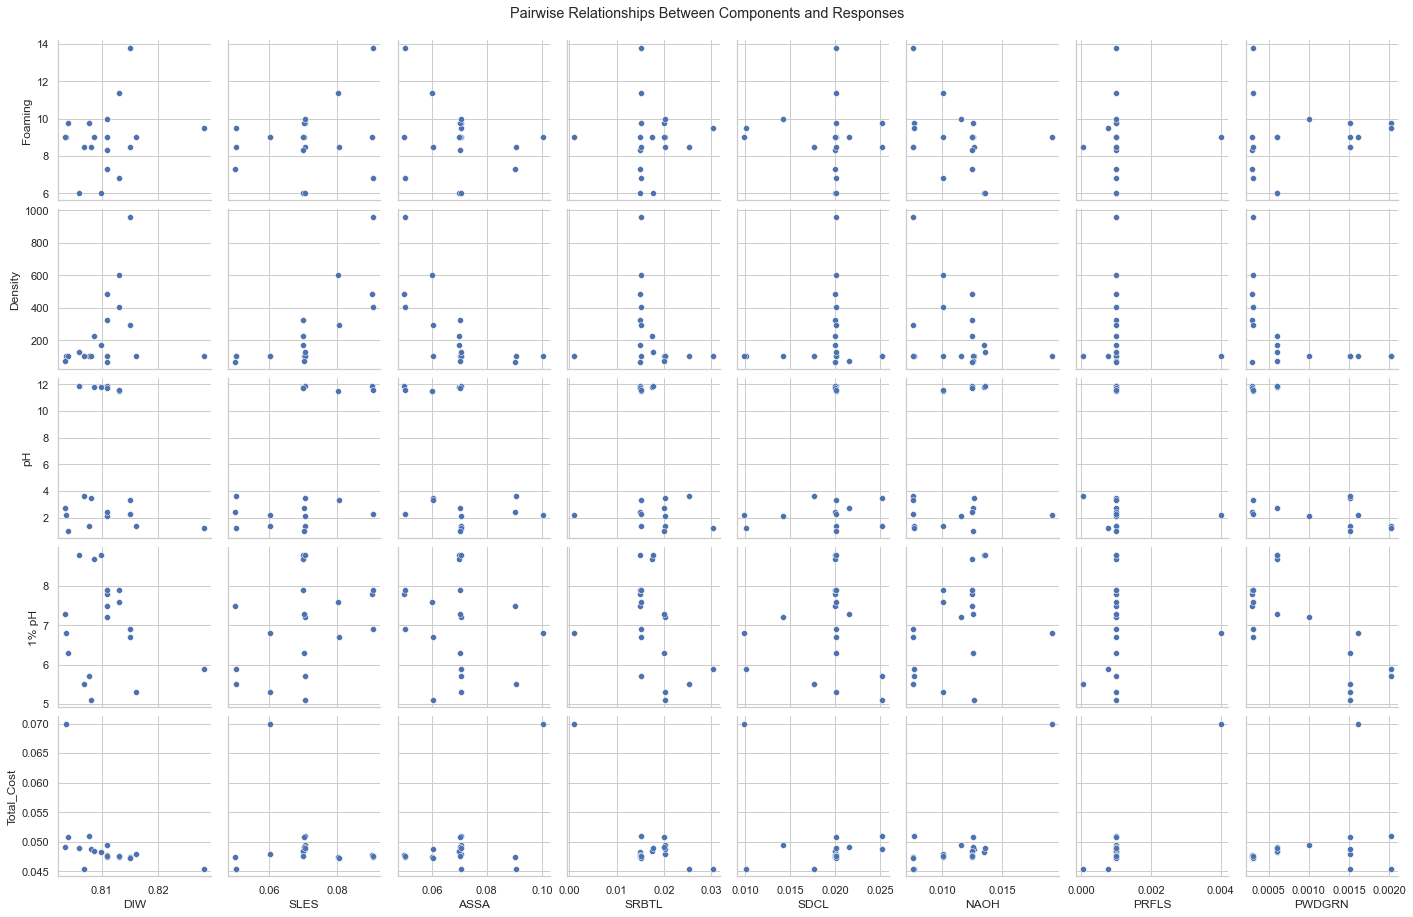

In [80]:
# Use pairplot with variables defined
sns.pairplot(df, x_vars=component_names, y_vars=response_names, diag_kind=None)
plt.suptitle('Pairwise Relationships Between Components and Responses', y=1.02)
plt.show()

/Users/anilsaddatbijoy/.pyenv/versions/3.6.9/envs/hmbrWork/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


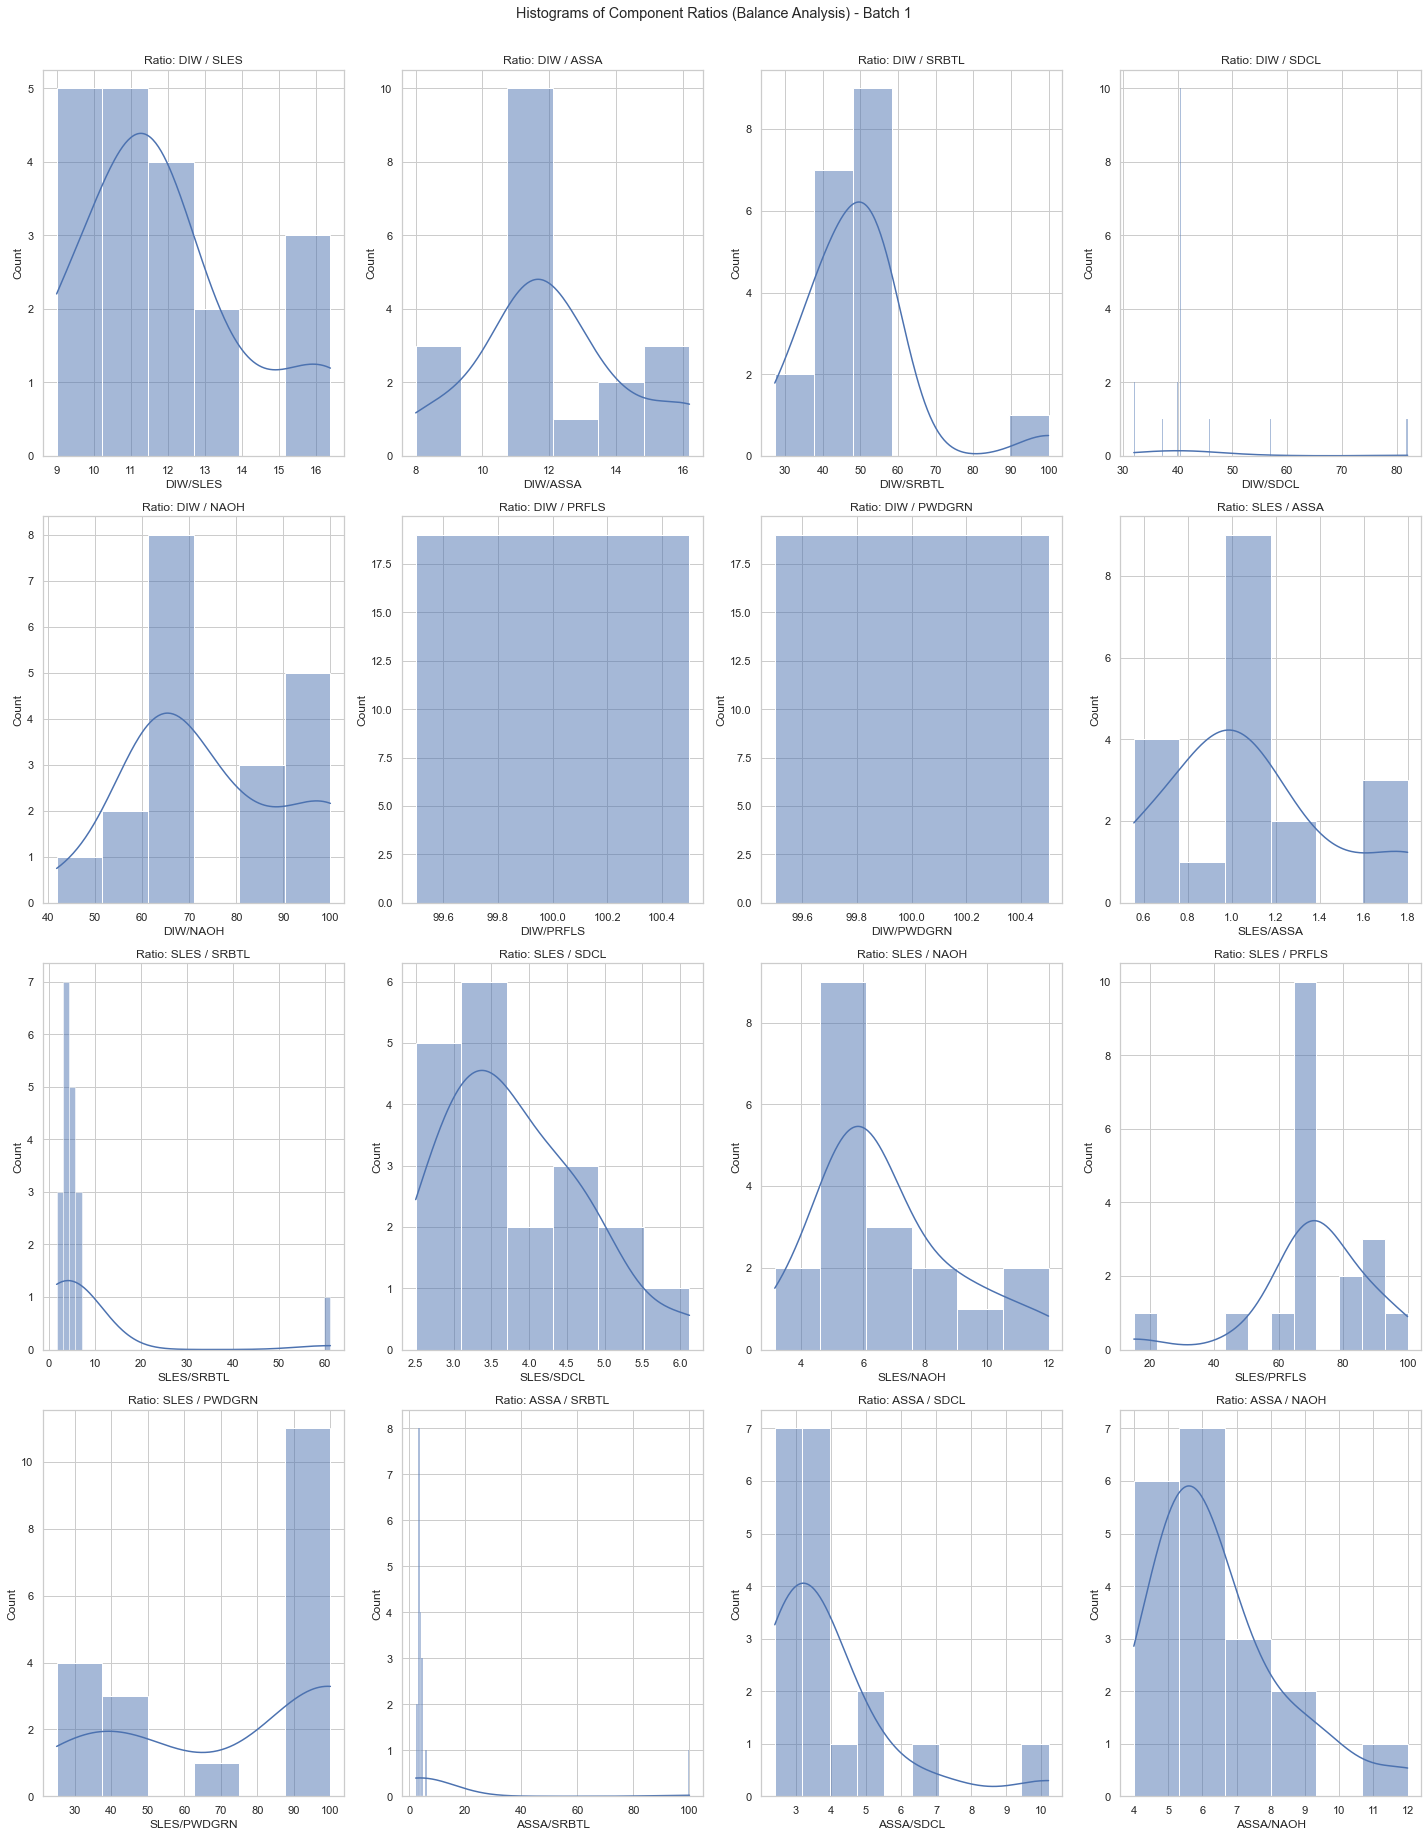

In [81]:
# Ratio plots of each components to check for balance 
component_pairs = list(itertools.combinations(component_names, 2))

# Value corrections and column creation
epsilon = 1e-6
for pair in component_pairs:
    component_1, component_2 = pair
    df_components[f'{component_1}/{component_2}'] = df_components[component_1] / (df_components[component_2] + epsilon)

# Eliminating large values
for col in df_components.columns[len(component_names):]:
    df_components[col] = df_components[col].clip(lower=0, upper=100)

plt.figure(figsize=(20, 25))
for idx, pair in enumerate(component_pairs[:16]):  
    plt.subplot(4, 4, idx + 1)  #
    sns.histplot(df_components[f'{pair[0]}/{pair[1]}'], kde=True)
    plt.title(f'Ratio: {pair[0]} / {pair[1]}')

plt.tight_layout()
plt.suptitle('Histograms of Component Ratios (Balance Analysis) - Batch 1', y=1.02)
plt.show()

In [82]:
# clr transform and check if correlation changes
def clr_transform(X):
    return np.log(X / np.exp(np.mean(np.log(X), axis=1, keepdims=True)))

# Apply CLR transformation to component columns
components = df[component_names].values
clr_components = clr_transform(components)
clr_df = pd.DataFrame(clr_components, columns=component_names)

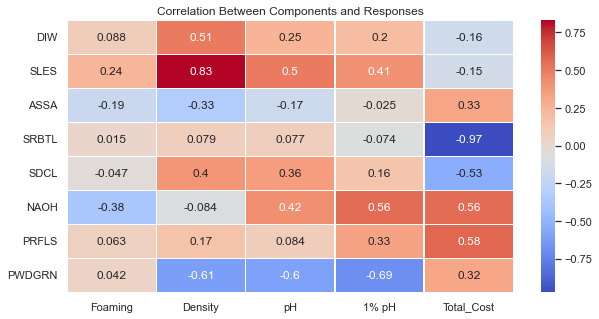

In [83]:
# correlation analysis - clr transformed
correlation_matrix_clr = pd.DataFrame(index=component_names, columns=response_names)

for component in component_names:
    for response in response_names:
        correlation_matrix_clr.loc[component, response] = clr_df[component].corr(df[response])

correlation_matrix_clr = correlation_matrix_clr.astype(float)


plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix_clr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Between Components and Responses')
plt.show()

In [154]:
# single response analysis
X = df[component_names]
y = df['Foaming']

In [161]:
# models of interest
models = {
    'LR': LinearRegression(),
    'PR2': Pipeline([
        ('poly_feat2', PolynomialFeatures(degree=2)),
        ('lin_reg2', LinearRegression())
    ]),
    'PR3': Pipeline([
        ('poly_feat3', PolynomialFeatures(degree=3)),
        ('lin_reg3', LinearRegression())
    ]),
    'DT': DecisionTreeRegressor(),
    'SVR': SVR(kernel='rbf')
}

In [162]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [163]:
# Iterate over each model to perform cross-validation and evaluate performance
results = {}

for model_name, model in models.items():
    if 'PR' in model_name:
        degree = 2 if '2' in model_name else 3
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X)
        lin_model = LinearRegression()
        scores = cross_val_score(lin_model, X_poly, y, cv=kf, scoring=make_scorer(r2_score))
        rmse_scores = cross_val_score(lin_model, X_poly, y, cv=kf, scoring=make_scorer(mean_squared_error))
    else:
        scores = cross_val_score(model, X, y, cv=kf, scoring=make_scorer(r2_score))
        rmse_scores = cross_val_score(model, X, y, cv=kf, scoring=make_scorer(mean_squared_error))
    
    results[model_name] = {
        'R2 Mean': np.mean(scores),
        'R2 Std Dev': np.std(scores),
        'RMSE Mean': np.mean(np.sqrt(rmse_scores)),
        'RMSE Std Dev': np.std(np.sqrt(rmse_scores))
    }

In [164]:
results_df_foaming = pd.DataFrame(results).T

In [123]:
results_df_density = pd.DataFrame(results).T

In [128]:
results_df_1pH = pd.DataFrame(results).T

In [133]:
results_df_cost = pd.DataFrame(results).T

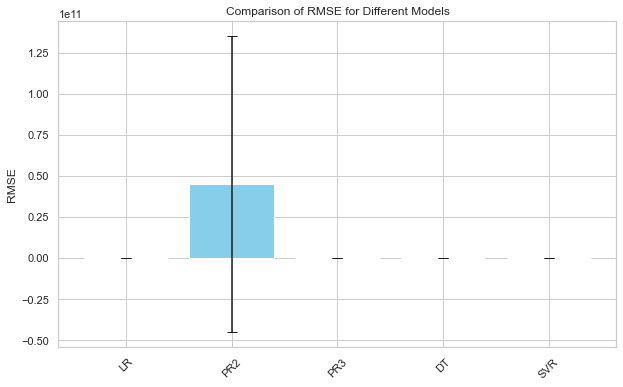

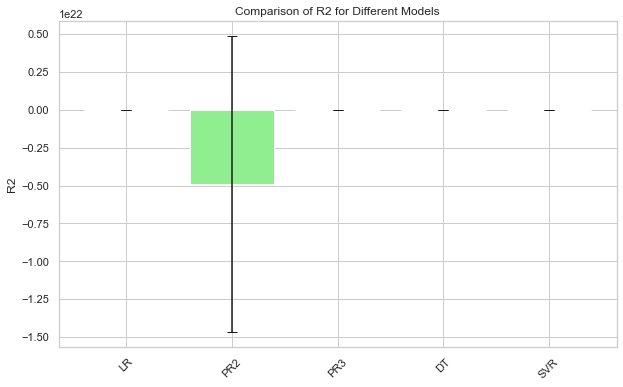

In [165]:
#Foaming
# RMSE plot
plt.figure(figsize=(10, 6))
plt.bar(results_df_foaming.index, results_df_foaming['RMSE Mean'], yerr=results_df_foaming['RMSE Std Dev'], color='skyblue', capsize=5)
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for Different Models')
plt.xticks(rotation=45)
plt.show()

# Plot R2 for Comparison of All Models
plt.figure(figsize=(10, 6))
plt.bar(results_df_foaming.index, results_df_foaming['R2 Mean'], yerr=results_df_foaming['R2 Std Dev'], color='lightgreen', capsize=5)
plt.ylabel('R2')
plt.title('Comparison of R2 for Different Models')
plt.xticks(rotation=45)
plt.show()

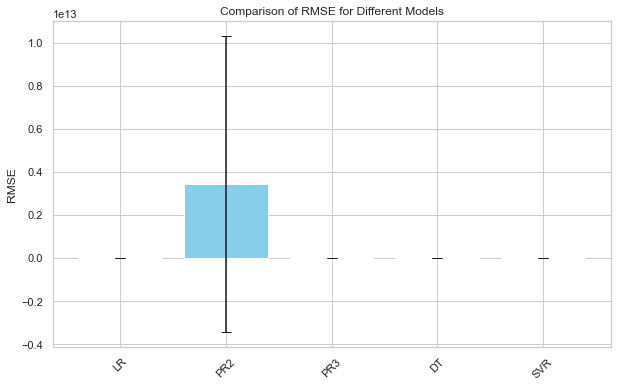

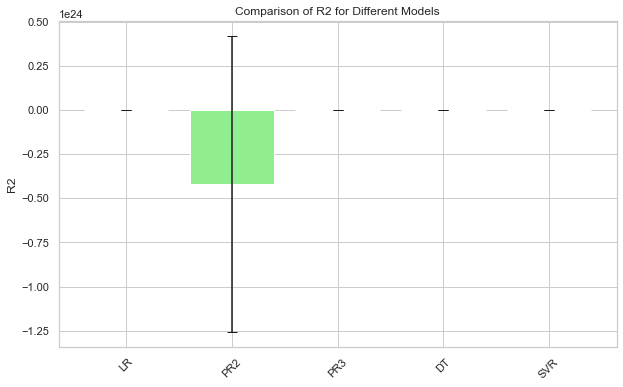

In [140]:
#Density
# RMSE plot
plt.figure(figsize=(10, 6))
plt.bar(results_df_density.index, results_df_density['RMSE Mean'], yerr=results_df_density['RMSE Std Dev'], color='skyblue', capsize=5)
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for Different Models')
plt.xticks(rotation=45)
plt.show()

# Plot R2 for Comparison of All Models
plt.figure(figsize=(10, 6))
plt.bar(results_df_density.index, results_df_density['R2 Mean'], yerr=results_df_density['R2 Std Dev'], color='lightgreen', capsize=5)
plt.ylabel('R2')
plt.title('Comparison of R2 for Different Models')
plt.xticks(rotation=45)
plt.show()

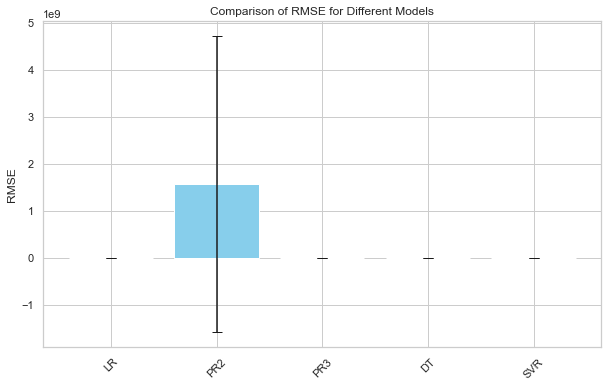

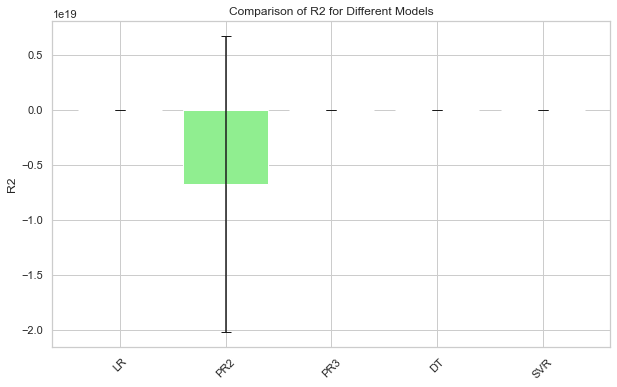

In [141]:
# 1% pH
# RMSE plot
plt.figure(figsize=(10, 6))
plt.bar(results_df_1pH.index, results_df_1pH['RMSE Mean'], yerr=results_df_1pH['RMSE Std Dev'], color='skyblue', capsize=5)
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for Different Models')
plt.xticks(rotation=45)
plt.show()

# Plot R2 for Comparison of All Models
plt.figure(figsize=(10, 6))
plt.bar(results_df_1pH.index, results_df_1pH['R2 Mean'], yerr=results_df_1pH['R2 Std Dev'], color='lightgreen', capsize=5)
plt.ylabel('R2')
plt.title('Comparison of R2 for Different Models')
plt.xticks(rotation=45)
plt.show()

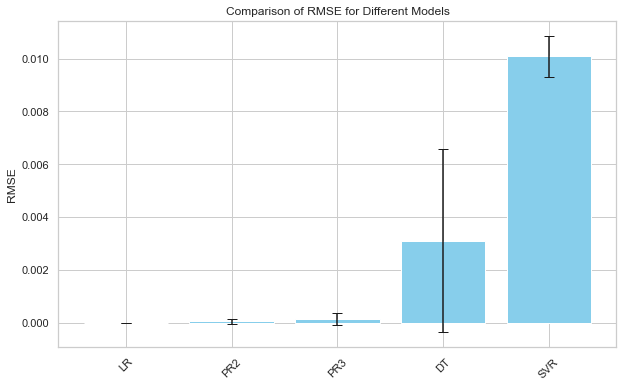

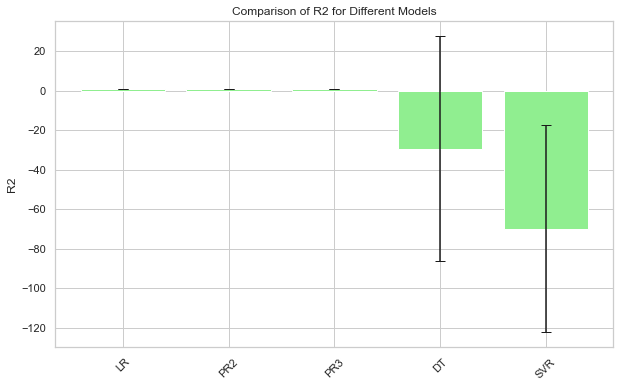

In [143]:
# Total_Cost
# RMSE plot
plt.figure(figsize=(10, 6))
plt.bar(results_df_cost.index, results_df_cost['RMSE Mean'], yerr=results_df_cost['RMSE Std Dev'], color='skyblue', capsize=5)
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for Different Models')
plt.xticks(rotation=45)
plt.show()

# Plot R2 for Comparison of All Models
plt.figure(figsize=(10, 6))
plt.bar(results_df_cost.index, results_df_cost['R2 Mean'], yerr=results_df_cost['R2 Std Dev'], color='lightgreen', capsize=5)
plt.ylabel('R2')
plt.title('Comparison of R2 for Different Models')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Should be a poly reg 2nd degree model but need to check 

In [ ]:
# most models are bad fits, large or even small R2, meaning model bad at predicting the mean,
# RMSE large predictor errors 
# need to try scaled features

In [192]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = df['Total_Cost']

In [193]:
models_scaled = {
    'LR': LinearRegression(),
    'PR2': Pipeline([
        ('poly_feat2', PolynomialFeatures(degree=2)),
        ('lin_reg2', LinearRegression())
    ]),
    'PR3': Pipeline([
        ('poly_feat3', PolynomialFeatures(degree=3)),
        ('lin_reg3', LinearRegression())
    ]),
    'DT': DecisionTreeRegressor(max_depth=5),
    'SVR': SVR(kernel='rbf', C=1.0, gamma='scale')  #parameter tuning (Need to learn more)
}

In [194]:
results_scaled = {}

for model_name, model in models_scaled.items():
    if 'PR' in model_name:
        degree = 2 if '2' in model_name else 3
        poly_scaled = PolynomialFeatures(degree=degree)
        X_poly_scaled = poly_scaled.fit_transform(X_scaled)
        lin_model = LinearRegression()
        scores = cross_val_score(lin_model, X_poly_scaled, y_scaled, cv=kf, scoring=make_scorer(r2_score))
        rmse_scores = cross_val_score(lin_model, X_poly_scaled, y_scaled, cv=kf, scoring=make_scorer(mean_squared_error))
    else:
        scores = cross_val_score(model, X_scaled, y_scaled, cv=kf, scoring=make_scorer(r2_score))
        rmse_scores = cross_val_score(model, X_scaled, y_scaled, cv=kf, scoring=make_scorer(mean_squared_error))
    
    results_scaled[model_name] = {
        'R2 Mean': np.mean(scores),
        'R2 Std Dev': np.std(scores),
        'RMSE Mean': np.mean(np.sqrt(rmse_scores)),
        'RMSE Std Dev': np.std(np.sqrt(rmse_scores))
    }

In [182]:
results_s_foaming = pd.DataFrame(results_scaled).T

In [187]:
results_s_density = pd.DataFrame(results_scaled).T

In [191]:
results_s_1pH = pd.DataFrame(results_scaled).T

In [195]:
results_s_cost = pd.DataFrame(results_scaled).T

In [ ]:
# SVR fits the individual models

In [199]:
results_s_cost

,R2 Mean,R2 Std Dev,RMSE Mean,RMSE Std Dev
LR,1.000000,0.000000,8.977041e-18,3.860928e-18
PR2,-0.777429,1.206339,3.660711e-03,4.582384e-03
PR3,0.333041,0.631369,2.118397e-03,2.541837e-03
DT,-0.460080,1.304335,5.770736e-03,4.911995e-03
SVR,-69.964603,52.461742,1.008975e-02,7.740065e-04


In [201]:
# data prep for multivariate - non scaled data
Xm = df[component_names]
ym = df[response_names]

In [202]:
# multivariate linear regression
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(Xm_train, ym_train)
ym_pred = model.predict(Xm_test)

In [204]:
for i, response in enumerate(response_names):
    r2 = r2_score(ym_test.iloc[:, i], ym_pred[:, i])
    rmse = mean_squared_error(ym_test.iloc[:, i], ym_pred[:, i], squared=False)
    print(f"Response: {response}")
    print(f"  R²: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")

Response: Foaming
  R²: -9.0011
  RMSE: 4.5546
Response: Density
  R²: -1142.3919
  RMSE: 401.2173
Response: pH
  R²: -32.5234
  RMSE: 25.7258
Response: 1% pH
  R²: -0.0553
  RMSE: 1.3944
Response: Total_Cost
  R²: 1.0000
  RMSE: 0.0000


In [205]:
#scaled_multivariate linear
Xms = scaler.fit_transform(Xm)
yms = df[response_names]

In [206]:
Xms_train, Xms_test, yms_train, yms_test = train_test_split(Xms, yms, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(Xms_train, yms_train)
yms_pred = model.predict(Xms_test)

In [208]:
for i, response in enumerate(response_names):
    r2 = r2_score(yms_test.iloc[:, i], yms_pred[:, i])
    rmse = mean_squared_error(yms_test.iloc[:, i], yms_pred[:, i], squared=False)
    print(f"Response: {response}")
    print(f"  R²: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")

Response: Foaming
  R²: -10.4558
  RMSE: 4.8746
Response: Density
  R²: -659.0728
  RMSE: 304.8442
Response: pH
  R²: -10.4482
  RMSE: 15.0336
Response: 1% pH
  R²: -0.2936
  RMSE: 1.5439
Response: Total_Cost
  R²: 1.0000
  RMSE: 0.0000


In [217]:
# non linear multivariate non scaled
multi_output_model = MultiOutputRegressor(DecisionTreeRegressor(max_depth=5))
multi_output_model.fit(Xm_train, ym_train)
ym_pred_multi = multi_output_model.predict(Xm_test)

In [218]:
for i, response in enumerate(response_names):
    r2 = r2_score(ym_test.iloc[:, i], ym_pred_multi[:, i])
    rmse = mean_squared_error(ym_test.iloc[:, i], ym_pred_multi[:, i], squared=False)
    print(f"Response: {response}")
    print(f"  R²: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")

Response: Foaming
  R²: -0.1927
  RMSE: 1.5729
Response: Density
  R²: -10.3401
  RMSE: 39.9567
Response: pH
  R²: -0.2329
  RMSE: 4.9336
Response: 1% pH
  R²: 0.1180
  RMSE: 1.2748
Response: Total_Cost
  R²: -0.4774
  RMSE: 0.0110


In [219]:
# non linear multivariate scaled
multi_output_models = MultiOutputRegressor(DecisionTreeRegressor(max_depth=5))
multi_output_models.fit(Xms_train, yms_train)
yms_pred_multi = multi_output_models.predict(Xms_test)

In [220]:
for i, response in enumerate(response_names):
    r2 = r2_score(yms_test.iloc[:, i], yms_pred_multi[:, i])
    rmse = mean_squared_error(yms_test.iloc[:, i], yms_pred_multi[:, i], squared=False)
    print(f"Response: {response}")
    print(f"  R²: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")

Response: Foaming
  R²: -1.1815
  RMSE: 2.1272
Response: Density
  R²: -4.3717
  RMSE: 27.5004
Response: pH
  R²: -0.2420
  RMSE: 4.9518
Response: 1% pH
  R²: 0.4125
  RMSE: 1.0404
Response: Total_Cost
  R²: -0.3089
  RMSE: 0.0104


In [228]:
# Beware of flattened objective functions
def objective_function_weighted(x, model, weight_vector):
    x = np.array(x).reshape(1, -1)
    x_scaled = scaler.transform(x)
    y_pred = model.predict(x_scaled)[0]
    regularization_penalty = np.sum(np.square(x))  # L2 regularization , try other regularization

    objective_value = np.sum(weight_vector * y_pred) + 0.01 * regularization_penalty

    print(f"Input: {x}, Predicted: {y_pred}, Objective Value: {objective_value}")
    return np.sum(weight_vector * y_pred)

In [229]:
response_weights = {
    'Foaming': 1,
    'Density': 1,
    'pH': 0,
    '1% pH': -1,
    'Total_Cost': -1
}

In [230]:
weight_vector = [response_weights[response] for response in response_names]

# bounds for each component
bounds = [(0.0, 1.0) for _ in component_names]

# Ensure component sum to 1
def constraint_sum(x):
    return np.sum(x) - 1
constraints = ({'type': 'eq', 'fun': constraint_sum})


x0 = [1 / len(component_names)] * len(component_names)

In [231]:
# Optimize - linear regression scaled
result_linear = minimize(objective_function_weighted, x0, args=(model, weight_vector), bounds=bounds, constraints=constraints)
optimal_combination_linear = result_linear.x
print("Optimal linear regression:", optimal_combination_linear)

# Optimize - decision tree model
result_dt = minimize(objective_function_weighted, x0, args=(multi_output_models, weight_vector), bounds=bounds, constraints=constraints)
optimal_combination_dt = result_dt.x
print("Optimal decision tree multi-output regression:", optimal_combination_dt)

#need to try random forest and gradientboosting

Input: [[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]], Predicted: [ 6.60422344e+02 -3.93813173e+04 -2.85959781e+03 -3.05609512e+02
  1.03025000e+00], Objective Value: -38416.31447786459
Input: [[0.12500001 0.125      0.125      0.125      0.125      0.125
  0.125      0.125     ]], Predicted: [-1.08287918e+07 -4.43562834e+09 -4.60378376e+08  2.75917951e+07
  1.03025000e+00], Objective Value: -4474048929.251977
Input: [[0.125      0.12500001 0.125      0.125      0.125      0.125
  0.125      0.125     ]], Predicted: [-1.08287918e+07 -4.43562834e+09 -4.60378378e+08  2.75917951e+07
  1.03025000e+00], Objective Value: -4474048929.251977
Input: [[0.125      0.125      0.12500001 0.125      0.125      0.125
  0.125      0.125     ]], Predicted: [-1.08287918e+07 -4.43562836e+09 -4.60378378e+08  2.75917950e+07
  1.03025000e+00], Objective Value: -4474048945.189477
Input: [[0.125      0.125      0.125      0.12500001 0.125      0.125
  0.125      0.125     ]], Predicted: [-1.08287918e+07 

In [ ]:
# Exploratory Data Analysis (EDA):

# Before fitting any model, you should perform EDA to get a sense of the relationship between the predictors and the response.
# Plot scatter plots or pair plots between the features and response to observe the trend. If you see curves or complex relationships, a simple linear model might not be sufficient.
# Model Selection Techniques:

# Cross-Validation: Use cross-validation to compare the performance of different models, such as simple linear regression, polynomial regression (different degrees), or other non-linear models like decision trees or support vector machines.
# Goodness of Fit Metrics: Metrics like R², adjusted R², RMSE, and residual analysis can help determine if the model is capturing the relationship well. If a linear model gives poor R² and adding polynomial terms improves it significantly, then a polynomial model may be appropriate.
# Degree of Polynomial:

# Selecting the correct degree of the polynomial is crucial. A degree that is too low may underfit the data, while a very high degree may overfit it.
# You can use techniques like grid search with cross-validation to determine the optimal polynomial degree. This involves trying several different degrees (e.g., 1 to 5) and choosing the one that yields the best performance metric on validation data.
# Regularization:

# High-degree polynomials can lead to overfitting due to their flexibility. To mitigate this, you can use regularization techniques such as Ridge (L2) or Lasso (L1) regression, which penalize large coefficients and help simplify the model.